<a href="https://colab.research.google.com/github/nraptisss/Hate-Speech-Detection-Thesis/blob/main/fine_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U imbalanced-learn
!pip install transformers
!pip install datasets
!pip install torch --upgrade
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow_io')
import logging
import time
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import spacy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from torch.optim import AdamW, RAdam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertForSequenceClassification, get_linear_schedule_with_warmup, logging as hf_logging
import nltk
nltk.download('stopwords')
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from collections import Counter
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertConfig


# Configure logging level to suppress warnings from transformers library
logging.basicConfig(level=logging.ERROR)
hf_logging.set_verbosity_error()

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 280

# Load the Davidson and ethos dataset
df_davidson = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
ethos_data = load_dataset('ethos', 'binary')
ethos_df = ethos_data['train'].to_pandas()

# Load the HateXplain dataset from Hugging Face
hatexplain_data = load_dataset('hatexplain')
hatexplain_df = hatexplain_data['train'].to_pandas()

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Load the OLID dataset
olid_train_df = pd.read_csv('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt', sep='\t', header=None, names=['tweet'])
olid_train_labels = pd.read_csv('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt', sep='\t', header=None, names=['class'])
olid_train_df = pd.concat([olid_train_df, olid_train_labels], axis=1)

# Load the additional hate speech dataset
additional_dataset_url = "https://raw.githubusercontent.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset/main/Dynamically%20Generated%20Hate%20Dataset%20v0.2.3.csv"
additional_dataset = pd.read_csv(additional_dataset_url)

stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    """
    Preprocess text data by removing URLs, mentions, hashtags,
    and punctuation, and applying lemmatization.
    """
    # Lowercase the text
    text = text.lower()

    # Replace URLs with 'URL'
    #text = re.sub(r'http\S+', 'URL', text)

    # Replace user mentions with '@username'
    #text = re.sub(r'@\w+', '@username', text)

    # Remove punctuation (except exclamation marks and question marks)
    #text = re.sub(r'[^\w\s!?\']+', '', text)

    # Apply lemmatization
    #doc = nlp(text)
    #words = [token.lemma_ for token in doc]

    # Remove stopwords
    #words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    #text = ' '.join(words)

    return text

# Combine the 'Hate Speech' and 'Offensive Language' classes in Davidson dataset by taking majority vote among annotators for each post.
label_map = {0: 0, 1: 0, 2: 1}
df_davidson['class'] = df_davidson['class'].map(label_map)

# Preprocess the text data using the preprocess_text function in Davidson dataset.
df_davidson['tweet'] = df_davidson['tweet'].apply(preprocess_text)

# Preprocess the text data using the preprocess_text function in Ethos dataset.
ethos_df['text'] = ethos_df['text'].apply(preprocess_text)

# Preprocess the HateXplain dataset using the preprocess_text function in HateXplain dataset.
hatexplain_df['post_tokens'] = hatexplain_df['post_tokens'].apply(lambda x: ' '.join(x)).apply(preprocess_text)

# Preprocess the text data using the preprocess_text function in OLID dataset.
olid_train_df['tweet'] = olid_train_df['tweet'].apply(preprocess_text)

# Select only the "text" and "label" columns from the additional dataset
additional_dataset = additional_dataset[["text", "label"]]

# Apply the preprocess_text function to the new dataset
additional_dataset['text'] = additional_dataset['text'].apply(preprocess_text)

# Transform class labels in the new dataset: "hate" to 1 and "nothate" to 0
additional_dataset['label'] = additional_dataset['label'].map({'hate': 1, 'nothate': 0})

# Rename columns in the new dataset to match the existing datasets
additional_dataset.rename(columns={'text': 'tweet', 'label': 'class'}, inplace=True)

# Filter only the "hate" examples from the new dataset
hate_examples = additional_dataset[additional_dataset['class'] == 1]

# Combine hate speech and offensive speech labels in HateXplain dataset by taking majority vote among annotators for each post.
hatexplain_df['label'] = hatexplain_df['annotators'].apply(lambda x: int(sum(x['label']) / len(x['label']) >= 1))

# Rename columns in Ethos and HateXplain datasets
ethos_df.rename(columns={'text': 'tweet', 'label': 'class'}, inplace=True)
hatexplain_df.rename(columns={'post_tokens': 'tweet', 'label': 'class'}, inplace=True)

# Combine the Davidson, Ethos, and HateXplain datasets.
df_combined = pd.concat([
    df_davidson[['tweet', 'class']],
    ethos_df[['tweet', 'class']],
    hatexplain_df[['tweet', 'class']],
    hate_examples
], axis=0)

# Combine the OLID dataset with the existing training data
df_combined = pd.concat([df_combined, olid_train_df], axis=0)

# Drop rows with missing values.
df_combined.dropna(subset=['class'], inplace=True)

# Print the shape of the combined dataset
print(f'Combined dataset shape: {df_combined.shape}')

# Print the number of samples in each class
print('Number of samples in each class:')
print(df_combined['class'].value_counts())

# Print the first few rows of the combined dataset
print('First few rows of the combined dataset:')
print(df_combined.head())

# Print the number of missing values in each column
print('Number of missing values in each column:')
print(df_combined.isnull().sum())

# Print the length of the longest text in the combined dataset
print('Length of the longest text:')
print(df_combined['tweet'].str.len().max())

# Print the average length of the text in the combined dataset
print('Average length of the text:')
print(df_combined['tweet'].str.len().mean())

total_rows = df_davidson.shape[0] + ethos_df.shape[0] + hatexplain_df.shape[0] + olid_train_df.shape[0]
if df_combined.shape[0] == total_rows:
    print('All data is included in the final dataset.')
else:
    print('Some data is missing from the final dataset.')


# Split the combined dataset into train and validation sets.
train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['class'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights = torch.tensor(class_weights).to(device)
class_weights = class_weights.float()

print(train_df['class'].value_counts())
print("Calculated Class Weights:", class_weights)


# Tokenize and pad the text data using the DistilBERT tokenizer.
train_inputs = tokenizer(train_df['tweet'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
train_labels = torch.tensor(train_df['class'].values)

val_inputs = tokenizer(val_df['tweet'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
val_labels = torch.tensor(val_df['class'].values)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/998 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

Combined dataset shape: (75255, 2)
Number of samples in each class:
1    40840
0    34415
Name: class, dtype: int64
First few rows of the combined dataset:
                                               tweet  class
0  !!! rt @mayasolovely: as a woman you shouldn't...      1
1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...      0
2  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...      0
3  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...      0
4  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...      0
Number of missing values in each column:
tweet    0
class    0
dtype: int64
Length of the longest text:
3347
Average length of the text:
114.02524749186101
Some data is missing from the final dataset.
1    32672
0    27532
Name: class, dtype: int64
Calculated Class Weights: tensor([1.0933, 0.9213], device='cuda:0')


<IPython.core.display.Javascript object>

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Hyperparameters:
Learning Rate: 0.0001
Weight Decay: 0.1
Batch Size: 64
Number of Epochs: 20
Gradient Accumulation Steps: 4
Max Gradient Norm: 1.0
Current Learning Rate: 0.0001


Epoch 1: 100%|██████████| 941/941 [00:53<00:00, 17.54it/s]


Epoch [1/20], Average Loss: 0.6937
Validation Accuracy: 0.510
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.65      0.55      6883
           1       0.57      0.39      0.47      8168

    accuracy                           0.51     15051
   macro avg       0.52      0.52      0.51     15051
weighted avg       0.53      0.51      0.50     15051

Validation AUC ROC: 0.529


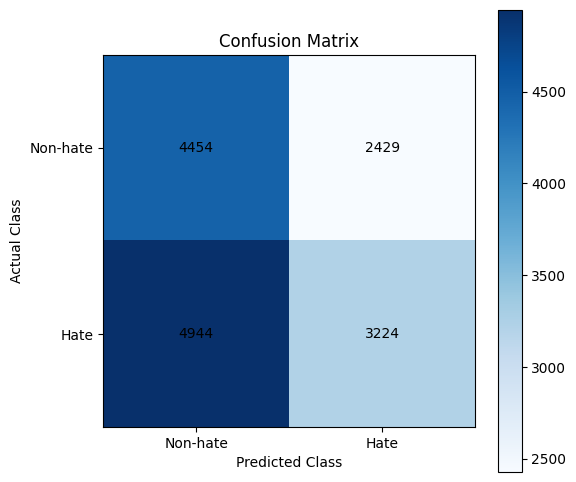

Current Learning Rate: 0.0001


Epoch 2: 100%|██████████| 941/941 [00:50<00:00, 18.60it/s]


Epoch [2/20], Average Loss: 0.6935
Validation Accuracy: 0.510
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.65      0.55      6883
           1       0.57      0.39      0.47      8168

    accuracy                           0.51     15051
   macro avg       0.52      0.52      0.51     15051
weighted avg       0.53      0.51      0.50     15051

Validation AUC ROC: 0.529


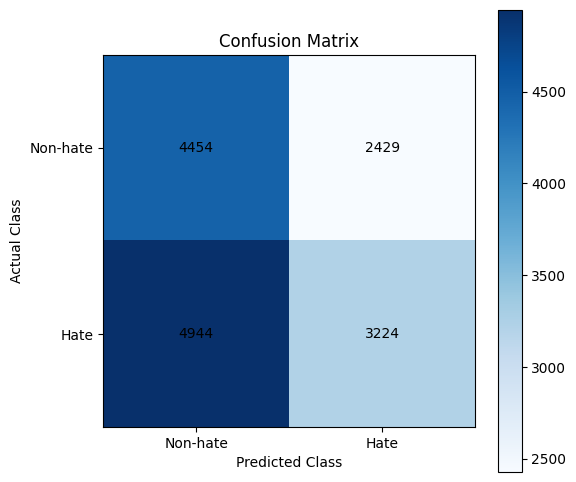

Current Learning Rate: 0.0001


Epoch 3: 100%|██████████| 941/941 [00:50<00:00, 18.76it/s]


Epoch [3/20], Average Loss: 0.6937
Validation Accuracy: 0.510
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.65      0.55      6883
           1       0.57      0.39      0.47      8168

    accuracy                           0.51     15051
   macro avg       0.52      0.52      0.51     15051
weighted avg       0.53      0.51      0.50     15051

Validation AUC ROC: 0.529


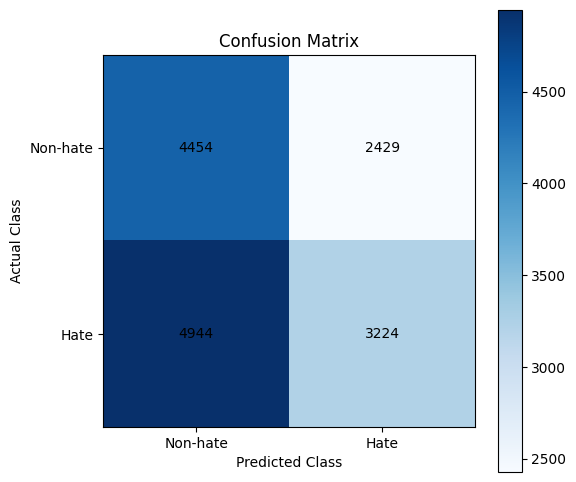

Current Learning Rate: 0.0001


Epoch 4: 100%|██████████| 941/941 [02:17<00:00,  6.85it/s, Loss=0.235]


Epoch [4/20], Average Loss: 0.3834
Validation Accuracy: 0.878
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6883
           1       0.87      0.91      0.89      8168

    accuracy                           0.88     15051
   macro avg       0.88      0.88      0.88     15051
weighted avg       0.88      0.88      0.88     15051

Validation AUC ROC: 0.948


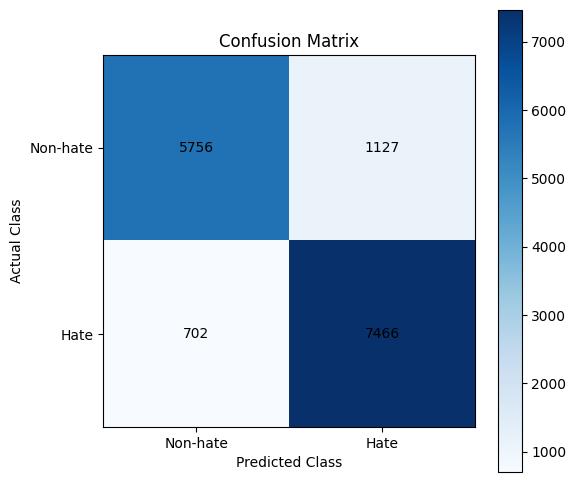

Current Learning Rate: 2e-05


Epoch 5: 100%|██████████| 941/941 [02:17<00:00,  6.86it/s, Loss=0.198]


Epoch [5/20], Average Loss: 0.2658
Validation Accuracy: 0.889
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6883
           1       0.90      0.90      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.957


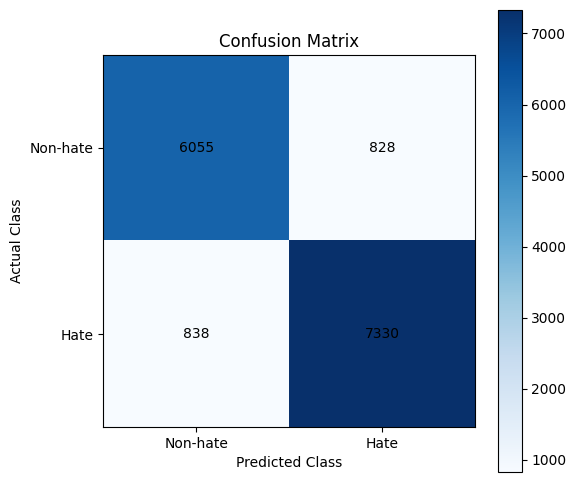

Current Learning Rate: 2e-05


Epoch 6: 100%|██████████| 941/941 [02:17<00:00,  6.86it/s, Loss=0.309]


Epoch [6/20], Average Loss: 0.2232
Validation Accuracy: 0.893
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6883
           1       0.89      0.91      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.960


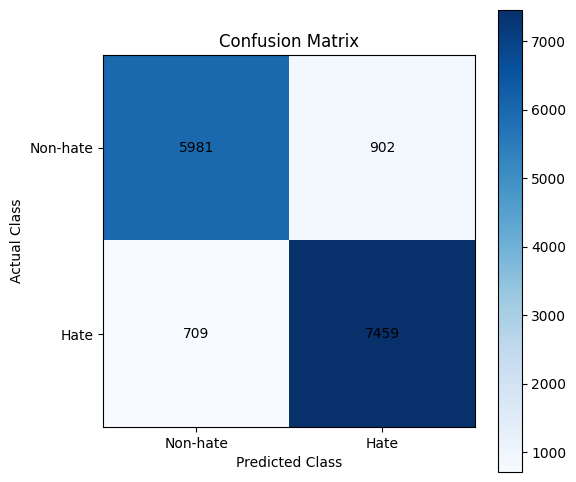

Current Learning Rate: 2e-05


Epoch 7: 100%|██████████| 941/941 [02:17<00:00,  6.86it/s, Loss=0.166]


Epoch [7/20], Average Loss: 0.1870
Validation Accuracy: 0.889
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6883
           1       0.90      0.89      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.957


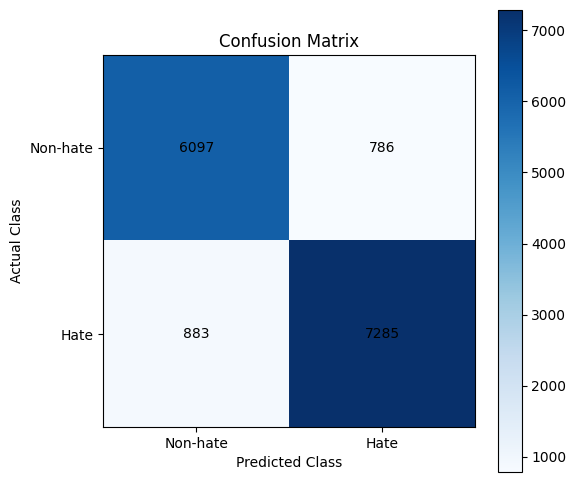

Current Learning Rate: 2e-05


Epoch 8: 100%|██████████| 941/941 [02:17<00:00,  6.85it/s, Loss=0.112]


Epoch [8/20], Average Loss: 0.1531
Validation Accuracy: 0.890
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      6883
           1       0.90      0.90      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.959


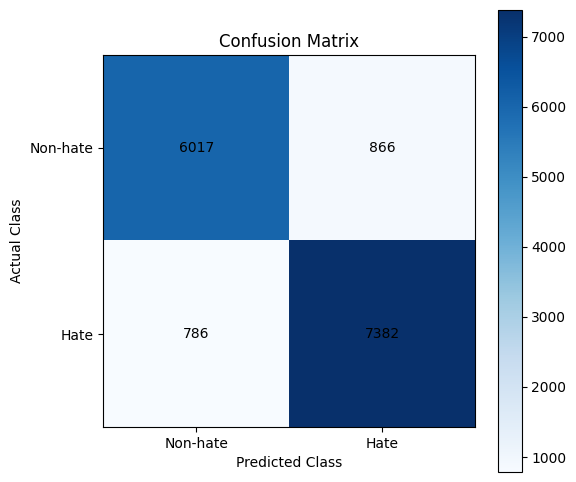

Current Learning Rate: 2e-05


Epoch 9: 100%|██████████| 941/941 [02:17<00:00,  6.85it/s, Loss=0.109]


Epoch [9/20], Average Loss: 0.1204
Validation Accuracy: 0.887
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      6883
           1       0.91      0.88      0.89      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.958


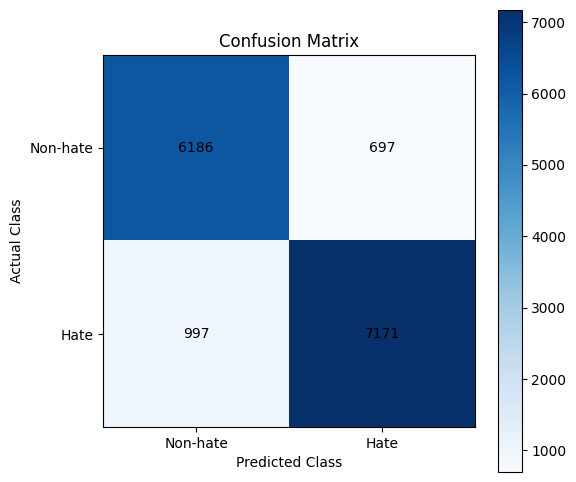

Current Learning Rate: 1e-05


Epoch 10: 100%|██████████| 941/941 [02:17<00:00,  6.85it/s, Loss=0.061]


Epoch [10/20], Average Loss: 0.0853
Validation Accuracy: 0.891
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6883
           1       0.89      0.91      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.957


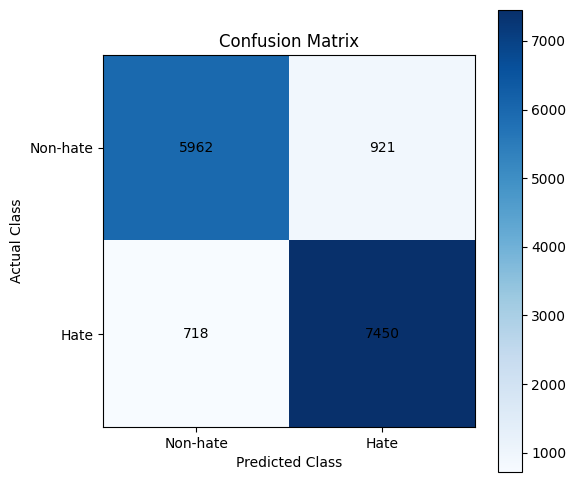

Current Learning Rate: 1e-05


Epoch 11: 100%|██████████| 941/941 [02:17<00:00,  6.85it/s, Loss=0.0533]


Epoch [11/20], Average Loss: 0.0697
Validation Accuracy: 0.891
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6883
           1       0.90      0.90      0.90      8168

    accuracy                           0.89     15051
   macro avg       0.89      0.89      0.89     15051
weighted avg       0.89      0.89      0.89     15051

Validation AUC ROC: 0.957
Early stopping triggered.


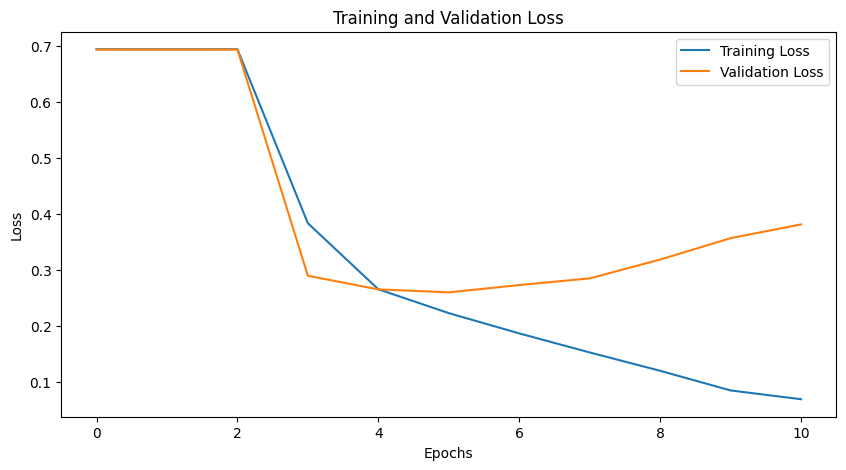

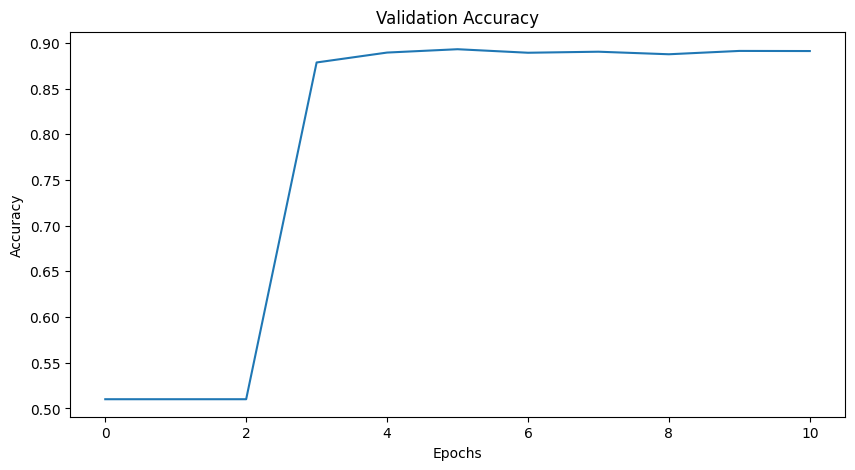

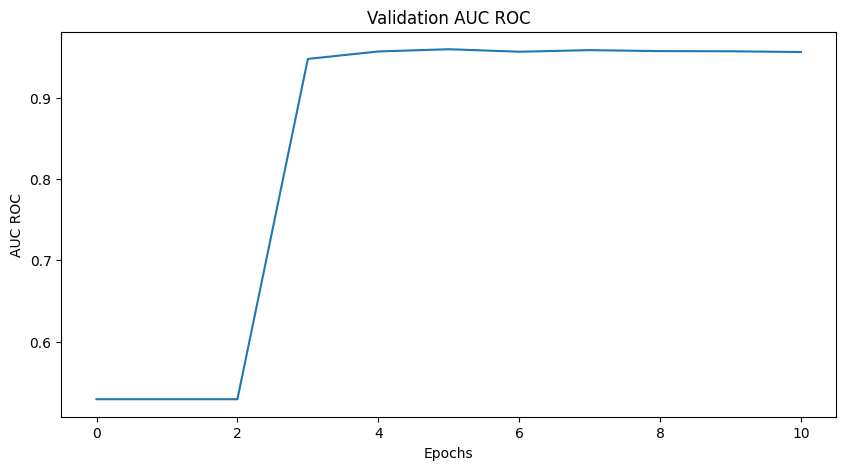

('distilbert_hate_speech_model/tokenizer_config.json',
 'distilbert_hate_speech_model/special_tokens_map.json',
 'distilbert_hate_speech_model/vocab.txt',
 'distilbert_hate_speech_model/added_tokens.json')

In [4]:
from google.colab import output
output.no_vertical_scroll()


import gc
gc.collect()
torch.cuda.empty_cache()

import matplotlib.pyplot as plt

# Define the DistilBERT model for sequence classification
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=1)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
print(model)
gc.collect()
torch.cuda.empty_cache()

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the pre-classifier and classifier
for param in model.pre_classifier.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Check if GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_inputs.to(device)
train_labels.to(device)
val_inputs.to(device)
val_labels.to(device)

num_epochs = 20

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay = 0.1)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Define the gradient scaler
scaler = GradScaler()

# Define the batch size
batch_size = 64

# Define the accumulation steps
accumulation_steps = 4

# Define the maximum gradient norm
max_grad_norm = 1.0

# Create an empty list to accumulate gradients
grad_accumulator = []

# Create a DataLoader for the training data
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store the metrics
train_losses = []
val_losses = []
val_accuracies = []
val_auc_rocs = []

# Initialize the patience and the best loss
patience = 5
best_val_loss = float('inf')
patience_counter = 0

print("Hyperparameters:")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Weight Decay: {optimizer.param_groups[0]['weight_decay']}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")
print(f"Gradient Accumulation Steps: {accumulation_steps}")
print(f"Max Gradient Norm: {max_grad_norm}")


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Print the current learning rate
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")

    # Unfreeze the model after 3 epochs
    if epoch == 3:
        for param in model.parameters():
            param.requires_grad = True
        # Adjust the learning rate
        for g in optimizer.param_groups:
            g['lr'] = 2e-5

    # Create a progress bar for the current epoch
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}')

    for step, batch in enumerate(progress_bar):
        # Forward pass
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with autocast():
            criterion = nn.BCEWithLogitsLoss()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze()

            # Convert labels to float data type
            labels = labels.float()
            loss = criterion(outputs, labels)

        # Backward pass and optimization only if the model is unfrozen
        if epoch >= 3:
            scaler.scale(loss).backward()

            # Accumulate gradients
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                # Unscale the gradients
                scaler.unscale_(optimizer)

                # Clip the gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                # Accumulate the unscaled gradients
                grad_accumulator.append(loss.item())

                # Update the model parameters
                scaler.step(optimizer)

                # Clear the gradients
                scaler.update()
                model.zero_grad()

                # Print the average loss over accumulation steps
                avg_loss = sum(grad_accumulator) / len(grad_accumulator)
                progress_bar.set_postfix({'Loss': avg_loss})

                # Clear the gradient accumulator
                grad_accumulator = []
            else:
                # Accumulate the unscaled gradients
                grad_accumulator.append(loss.item())

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Append the average training loss to train_losses
    train_losses.append(average_loss)

    # Evaluate the model on the validation set
    model.eval()

    # Create a DataLoader for the validation data
    val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    val_predictions = []
    val_probabilities = []
    val_total_loss = 0.0

    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze()
            predictions = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            val_predictions.extend(predictions)
            val_probabilities.extend(probabilities)
            labels = labels.float()
            val_total_loss += criterion(outputs, labels).item()

    # Calculate the average validation loss
    val_average_loss = val_total_loss / len(val_dataloader)

    # Update the scheduler with the validation loss
    scheduler.step(val_average_loss)

    val_predictions = np.array(val_predictions)
    val_accuracy = (val_predictions == val_df['class'].values).mean()
    val_classification_report = classification_report(val_df['class'].values, val_predictions)

    # Calculate the AUC ROC score
    val_auc_roc = roc_auc_score(val_df['class'].values, val_probabilities)

    # Append the metrics to the corresponding lists
    val_average_loss = val_total_loss / len(val_dataloader)
    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)
    val_auc_rocs.append(val_auc_roc)


    print(f'Validation Accuracy: {val_accuracy:.3f}')
    print('Classification Report:')
    print(val_classification_report)
    print(f'Validation AUC ROC: {val_auc_roc:.3f}')

     # Check if the validation loss improved
    if val_average_loss < best_val_loss:
        best_val_loss = val_average_loss
        patience_counter = 0
    else:
        patience_counter += 1

    # If the validation loss didn't improve for 'patience' epochs, stop training
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

    # Calculate the confusion matrix
    cm = confusion_matrix(val_df['class'].values, val_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.xticks([0,1], ['Non-hate', 'Hate'])
    plt.yticks([0,1], ['Non-hate', 'Hate'])
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]), ha='center', va='center', color='black')
    plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

# Plot validation AUC ROC
plt.figure(figsize=(10, 5))
plt.plot(val_auc_rocs)
plt.xlabel('Epochs')
plt.ylabel('AUC ROC')
plt.title('Validation AUC ROC')
plt.show()

# Save the trained model
model.save_pretrained('distilbert_hate_speech_model')
tokenizer.save_pretrained('distilbert_hate_speech_model')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil

# Replace 'My Drive/path_to_your_folder' with the path to the folder where you want to save your files in your Drive
shutil.move('distilbert_hate_speech_model', '/content/drive/My Drive/path_to_your_folder/distilbert_hate_speech_model')

'/content/drive/My Drive/path_to_your_folder/distilbert_hate_speech_model'